# Figure 3 Analysis: The Effect of Abundance-Based Sampling on Diversity Dynamics and Haar Fluctuation Analysis for a Neutral Community

Recall that this analysis is only run on the UNTB communities since the species-level model does not have individuals for which an abundance-based bias can be applied to.

In [ ]:
# Set User Paths #
src_path = "../Blind_Review_Code_Repository_2025/src/"


In [2]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib
import scipy

## Simulate UNTB Model

In [3]:
# Simulation Parameters
J = 100 # Community Size
mutation_p = 0.05 # Mutation probability
death_r = 10 # Death rate
model_n = 12000 # Simulation length
cut = 2000 # Burn-in time
expanded_community = np.repeat(1,J) # Initalize mono-dominante community

time_v = np.arange(cut, model_n) # Create time vector
tc = analysisFunctions.firstEigen(death_r, mutation_p, J) # Estimate of community characteristic timescale
# Print simulation parameters
print(f"Relaxation Time in log-time: {np.round(np.log10(1/tc),2)}; Death Rate: {death_r}; Speciation Rate: {mutation_p}")


#### If you want to do a more exhuastive grid search
'''
n_repeats = 1
k = 8
species_filter = [1, 25, 50] # Minimum species duration to include in analysis; units are timesteps
prob = [1.0, 0.5, 0.1] # Probability of sampling each individual at each timestep
grid = pd.DataFrame(list(product(species_filter, prob)), columns=["species_filter", "prob"])

prob_S = grid["prob"].iloc[k]
filter_threshold = grid["species_filter"].iloc[k]
'''

# These are the parameters presented within the plot 
prob_S = 0.1
filter_threshold = 50

print(f"Sampling Probability: {prob_S}; Filter threshold: {filter_threshold}")

# Change save name for other parameter combinations if desired
save_name = f"Fig3_SP10_FT50_J100_DR10_SR_05"

Relaxation Time in log-time: 2.3; Death Rate: 10; Speciation Rate: 0.05
Sampling Probability: 0.1; Filter threshold: 50


In [4]:
# Simulate
untb_results, ancs, desc, n_muts = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= mutation_p, death_rate= death_r, generations=model_n, keep=False)

###################
# Analysis Starts #
###################
# Form species list
species_list_all = np.arange(1, np.max(untb_results)+1, dtype = np.int64)
set_num_threads(8) # Set thread number
spec_dyn = samplingFunctions.retrieve_species_dynamics_numba(untb_results, species_id = species_list_all)

In [5]:
# Unbiased Case

unbiased_curve = []

unbiased_r2f3 = []
unbiased_ori_2f3 = []
unbiased_exi_2f3 = []

unbiased_hr_2f3 = []
unbiased_or_2f3 = []
unbiased_er_2f3 = []  
unbiased_ht_2f3 = []

unbiased_corr_oe_2f3 = []
unbiased_cor_ed_2f3 = []
unbiased_corr_od_2f3 = []

###################
# Unbiased Output #
###################
# Bias the output
test_spec = np.array(spec_dyn.copy(), dtype=np.int64)
presence = test_spec[cut:] # Discard burn-in period
# Get metrics

# Filter out time steps you will not observe
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
unbiased_curve.append(a6[sorted_indices, 3])

# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
unbiased_r2f3.append(divRT)
unbiased_ori_2f3.append(org2f3)
unbiased_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
unbiased_hr_2f3.append(haar_Div)
unbiased_or_2f3.append(haar_oriRT)
unbiased_er_2f3.append(haar_extRT)   
unbiased_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
unbiased_corr_oe_2f3.append(corr_org_ext)
unbiased_cor_ed_2f3.append(corr_ext_div)
unbiased_corr_od_2f3.append(corr_ori_div) 

/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:134: RuntimeWarning: invalid value encountered in divide
  ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:143: RuntimeWarning: invalid value encountered in divide
  ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/crossHaarCorrelation.py:29: RuntimeWarning: invalid value encountered in scalar divide
  tmp[i] = num / dem


In [6]:
# Applying Abundance Bias

sp_curve = []

sp_r2f3 = []
sp_ori_2f3 = []
sp_exi_2f3 = []

sp_hr_2f3 = []
sp_or_2f3 = []
sp_er_2f3 = []  
sp_ht_2f3 = []

sp_corr_oe_2f3 = []
sp_cor_ed_2f3 = []
sp_corr_od_2f3 = []

###########################
# Applying Abundance Bias #
###########################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
sp_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
sp_r2f3.append(divRT)
sp_ori_2f3.append(org2f3)
sp_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
sp_hr_2f3.append(haar_Div)
sp_or_2f3.append(haar_oriRT)
sp_er_2f3.append(haar_extRT)   
sp_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
sp_corr_oe_2f3.append(corr_org_ext)
sp_cor_ed_2f3.append(corr_ext_div)
sp_corr_od_2f3.append(corr_ori_div) 

/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:134: RuntimeWarning: invalid value encountered in divide
  ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:143: RuntimeWarning: invalid value encountered in divide
  ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])


In [7]:
# Abundance and Truncation Case

ab_curve = []

ab_r2f3 = []
ab_ori_2f3 = []
ab_exi_2f3 = []

ab_hr_2f3 = []
ab_or_2f3 = []
ab_er_2f3 = []  
ab_ht_2f3 = []

ab_corr_oe_2f3 = []
ab_cor_ed_2f3 = []
ab_corr_od_2f3 = []

##########################################
# Applying Abundance and Truncation Bias #
##########################################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
TF = filter_threshold ### Threshold Value ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] > TF]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
ab_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
ab_r2f3.append(divRT)
ab_ori_2f3.append(org2f3)
ab_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
ab_hr_2f3.append(haar_Div)
ab_or_2f3.append(haar_oriRT)
ab_er_2f3.append(haar_extRT)   
ab_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
ab_corr_oe_2f3.append(corr_org_ext)
ab_cor_ed_2f3.append(corr_ext_div)
ab_corr_od_2f3.append(corr_ori_div) 

## Main Figure 3 Plot

In [ ]:
# Set tiff save path
tiff_save_path_1 = f"../{save_name}.tiff"

In [8]:
# Calculate mean convergence time for community turnover distributions
colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']

datasets = [
    unbiased_exi_2f3[0] - unbiased_ori_2f3[0],
    sp_exi_2f3[0] - sp_ori_2f3[0],
    ab_exi_2f3[0] - ab_ori_2f3[0]
]

t = datasets[0].shape[0]

running_means = []

for data in datasets:
    means = [np.nanmean(data[:i]) for i in range(2, t)]
    running_means.append(means)
samples = np.arange(2, t)

In [9]:
target_means = [
    np.mean(running_means[0][7500:]),
    np.mean(running_means[1][7500:]),
    np.mean(running_means[2][7500:])
]

def convergence_rate(x, target_mean):
    En = np.asarray(x) - target_mean
    return En

cr1 = convergence_rate(running_means[0],target_means[0])
cr2 = convergence_rate(running_means[1],target_means[1])
cr3 = convergence_rate(running_means[2],target_means[2])

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71030/188333871.py:16: RuntimeWarning: divide by zero encountered in log10
  axs[0, 1].plot(np.log10(unbiased_curve[0]), c=colors[0])


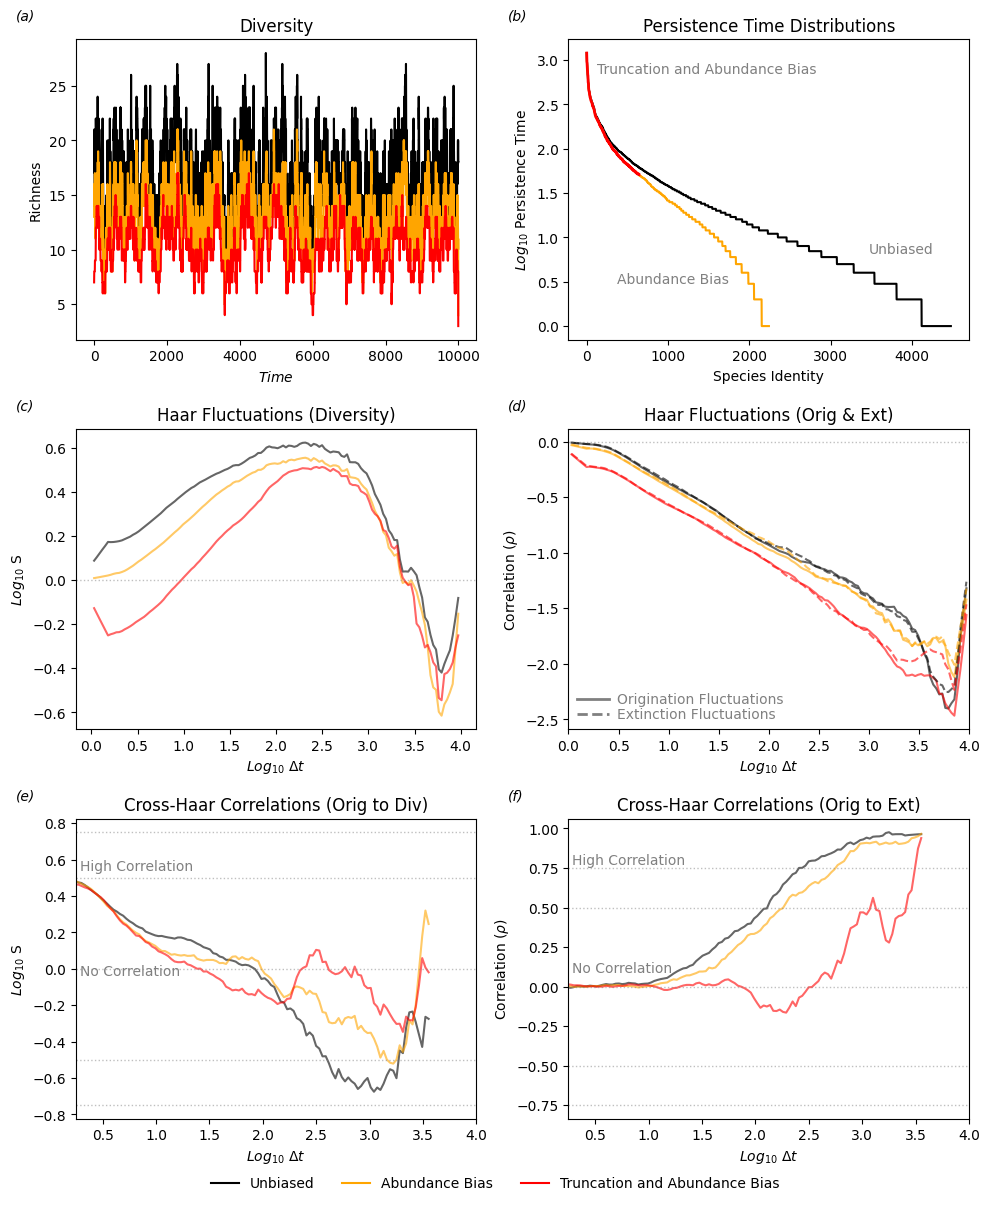

In [11]:
# Main Figure 3
cmap = plt.get_cmap('magma', 3)
colors = [cmap(i) for i in range(3)]  # 3 variants: Unbiased, Abundance Bias, Truncation+Abundance
colors = ["black", "orange", "red"]
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
K = 10 # Convolution kernal window size

### a
# Diversity Curves
axs[0, 0].plot(np.arange(len(unbiased_r2f3[0][5:])), unbiased_r2f3[0][5:], c=colors[0], label="Unbiased")
axs[0, 0].plot(np.arange(len(sp_r2f3[0][5:])), sp_r2f3[0][5:], c=colors[1], label="Abundance Bias")
axs[0, 0].plot(np.arange(len(ab_r2f3[0][5:])), ab_r2f3[0][5:], c=colors[2], label="Truncation and Abundance")
axs[0, 0].set_title("Diversity")
### b
# Persistence Curves
axs[0, 1].plot(np.log10(unbiased_curve[0]), c=colors[0])
axs[0, 1].plot(np.log10(sp_curve[0]), c=colors[1])
axs[0, 1].plot(np.log10(ab_curve[0]), c=colors[2], linewidth = 2)
axs[0, 1].set_title("Persistence Time Distributions")

# Convolution Kernel Window
### c
# Haar Diversity
axs[1, 0].plot(np.log10(unbiased_hr_2f3[0][:, 0]), np.convolve(np.log10(unbiased_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[1, 0].plot(np.log10(sp_hr_2f3[0][:, 0]), np.convolve(np.log10(sp_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[1, 0].plot(np.log10(ab_hr_2f3[0][:, 0]), np.convolve(np.log10(ab_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[1, 0].set_title("Haar Fluctuations (Diversity)")

### d
# Origination Haar
axs[1, 1].plot(np.log10(unbiased_or_2f3[0][:, 0]), np.convolve(np.log10(unbiased_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[1, 1].plot(np.log10(sp_or_2f3[0][:, 0]), np.convolve(np.log10(sp_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[1, 1].plot(np.log10(ab_or_2f3[0][:, 0]), np.convolve(np.log10(ab_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[1, 1].set_title("Haar Fluctuations (Orig & Ext)")
# Extinction Haar
axs[1, 1].plot(np.log10(unbiased_er_2f3[0][:, 0]), np.convolve(np.log10(unbiased_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6, linestyle = "dashed")
axs[1, 1].plot(np.log10(sp_er_2f3[0][:, 0]), np.convolve(np.log10(sp_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6, linestyle = "dashed")
axs[1, 1].plot(np.log10(ab_er_2f3[0][:, 0]), np.convolve(np.log10(ab_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6, linestyle = "dashed")

### e
# Cross-Haar Correlations
axs[2, 0].plot(np.log10(unbiased_or_2f3[0][:, 0]),  np.convolve(unbiased_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[2, 0].plot(np.log10(sp_or_2f3[0][:, 0]),  np.convolve(sp_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[2, 0].plot(np.log10(ab_or_2f3[0][:, 0]),  np.convolve(ab_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[2, 0].set_title("Cross-Haar Correlations (Orig to Div)")

# Add horizontal reference lines
for y in [0.75, -0.75, 0.5, -0.5, 0]:
    axs[2, 0].axhline(y, color="gray", linestyle=':', linewidth=1, alpha=0.5)

### f
# Cross-Haar Correlations
axs[2, 1].plot(np.log10(unbiased_or_2f3[0][:, 0]), np.convolve(unbiased_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[2, 1].plot(np.log10(sp_or_2f3[0][:, 0]), np.convolve(sp_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[2, 1].plot(np.log10(ab_or_2f3[0][:, 0]), np.convolve(ab_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[2, 1].set_title("Cross-Haar Correlations (Orig to Ext)")

# Add horizontal reference lines
for y in [0.75, -0.75, 0.5, -0.5, 0]:
    axs[2, 1].axhline(y, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# Set layout
fig.tight_layout()

# Shared legend outside the plot
fig.legend(["Unbiased", "Abundance Bias", "Truncation and Abundance Bias"], 
           loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.01))

# labels
axs[0,0].set_xlabel(r'$Time$')
axs[0,0].set_ylabel(r'Richness')
axs[0,1].set_xlabel(r'Species Identity')
axs[0,1].set_ylabel(r'$Log_{10}$ Persistence Time')

axs[1,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,0].set_ylabel(r'$Log_{10}$ S')
axs[1,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,1].set_ylabel(r'Correlation $(\rho)$')

axs[2,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,0].set_ylabel(r'$Log_{10}$ S')
axs[2,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,1].set_ylabel(r'Correlation $(\rho)$')

subplot_letters = [
"(a)", "(b)","(c)", "(d)",
"(e)", "(f)"
]

# Plot Letters
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(-0.15, 1.1, subplot_letters[idx], transform=ax.transAxes,
            fontsize=10, fontstyle='italic', va='top', ha='left')

# Figures Text Captions 
font_s = 10
# (b)
axs[0, 1].text(0.07, 0.9, "Truncation and Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.12, 0.2, "Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.75, 0.3, "Unbiased",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 0].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# (c)
axs[1, 1].plot([0.02, 0.10], [0.1, 0.1],transform=axs[1, 1].transAxes,color='grey',linewidth=2,linestyle='-',clip_on=False)
axs[1, 1].text(0.12, 0.1, "Origination Fluctuations",transform=axs[1, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].plot([0.02, 0.10], [0.05, 0.05],transform=axs[1, 1].transAxes,color='grey',linewidth=2,linestyle='--',clip_on=False)
axs[1, 1].text(0.12, 0.05, "Extinction Fluctuations",transform=axs[1, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)
axs[1, 1].set_xlim(0, 4)

# (d)
axs[2, 0].text(0.01, 0.84, "High Correlation", transform=axs[2, 0].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 0].text(0.01, 0.49, "No Correlation", transform=axs[2, 0].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 0].set_xlim(0.25, 4)

# (e)
axs[2, 1].text(0.01, 0.86, "High Correlation", transform=axs[2, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 1].text(0.01, 0.50, "No Correlation", transform=axs[2, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 1].set_xlim(0.25, 4)

plt.tight_layout(h_pad=0.75, w_pad=0.4)
plt.subplots_adjust(bottom=0.06)  # Extra space for legend

plt.savefig(tiff_save_path_1, format='tiff', dpi=300, bbox_inches='tight',transparent=True)

Unbiased: 2.2878279670462573; slightly biased: 2.4082399653118496; super biased: 2.468445964444646


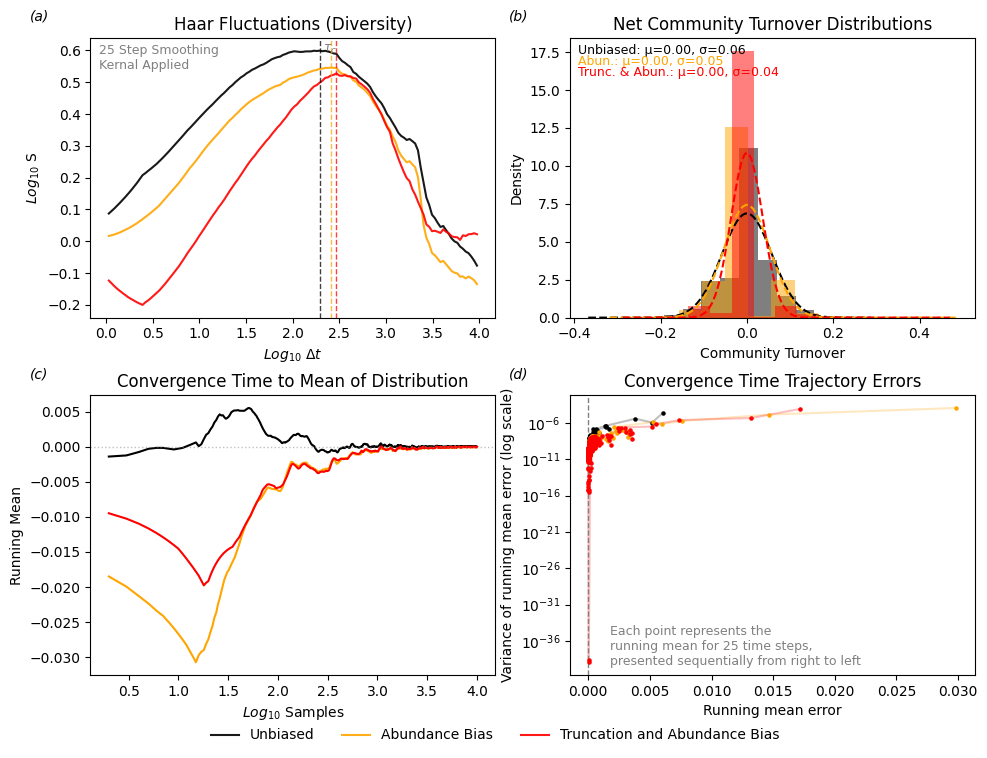

In [ ]:
# Supplement subpanels from Figure 3
tiff_save_path_2 = "../Jan14_Fig3_supp.tiff"

colors = ["black", "orange", "red"]  # 3 variants: Unbiased, Abundance Bias, Truncation+Abundance
legends_n = ["Unbiased", "Abundance Bias", "Truncation and Abundance Bias"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
window = 25 # Convolution kernel window size
font_s = 9  # default font size for annotations

### a. Haar Diversity
axs[0, 0].plot(np.log10(unbiased_hr_2f3[0][:, 0]), 
               np.convolve(np.log10(unbiased_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'), 
               color=colors[0], alpha=0.9)
axs[0, 0].plot(np.log10(sp_hr_2f3[0][:, 0]), 
               np.convolve(np.log10(sp_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'), 
               color=colors[1], alpha=0.9)
axs[0, 0].plot(np.log10(ab_hr_2f3[0][:, 0]), 
               np.convolve(np.log10(ab_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'), 
               color=colors[2], alpha=0.9)
axs[0, 0].set_title("Haar Fluctuations (Diversity)")

# Add Tc line
max_1 = np.log10(unbiased_hr_2f3[0][:, 0])[np.argmax(np.convolve(np.log10(unbiased_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'))]
axs[0, 0].axvline(max_1, linewidth = 1, linestyle = "dashed", c = colors[0], alpha = 0.75)
max_2 = np.log10(sp_hr_2f3[0][:, 0])[np.argmax(np.convolve(np.log10(sp_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'))]
axs[0, 0].axvline(max_2, linewidth = 1, linestyle = "dashed", c = colors[1], alpha = 0.75)
max_3 = np.log10(ab_hr_2f3[0][:, 0])[np.argmax(np.convolve(np.log10(ab_hr_2f3[0][:, 1]), np.ones(window)/window, mode='same'))]
axs[0, 0].axvline(max_3, linewidth = 1, linestyle = "dashed",  c = colors[2], alpha = 0.75)
print(f"Unbiased: {max_1}; slightly biased: {max_2}; super biased: {max_3}")
### b. Turnover distributions (fits only)
axs[0, 1].hist(unbiased_exi_2f3[0] - unbiased_ori_2f3[0], bins=15, color=colors[0], label="Unbiased", alpha=0.5, density=True)
axs[0, 1].hist(sp_exi_2f3[0] - sp_ori_2f3[0], bins=15, color=colors[1], label="Abundance Bias", alpha=0.5, density=True)
axs[0, 1].hist(ab_exi_2f3[0] - ab_ori_2f3[0], bins=15, color=colors[2], label="Truncation and Abundance", alpha=0.5, density=True)

pdf, x, me1, sd1 = analysisFunctions.moment_curve(unbiased_exi_2f3[0] - unbiased_ori_2f3[0])
axs[0, 1].plot(x, pdf, color=colors[0], linestyle='--', label=f'Unbiased Fit (μ={me1:.2f}, σ={sd1:.2f})')
pdf, x, me2, sd2 = analysisFunctions.moment_curve(sp_exi_2f3[0] - sp_ori_2f3[0])
axs[0, 1].plot(x, pdf, color=colors[1], linestyle='--', label=f'Abundance Bias Fit (μ={me2:.2f}, σ={sd2:.2f})')
pdf, x, me3, sd3 = analysisFunctions.moment_curve(ab_exi_2f3[0] - ab_ori_2f3[0])
axs[0, 1].plot(x, pdf, color=colors[2], linestyle='--', label=f'Truncation & Abundance Fit (μ={me3:.2f}, σ={sd3:.2f})')
axs[0, 1].set_title("Net Community Turnover Distributions")
axs[0, 1].set_ylabel("Density")
axs[0, 1].set_xlabel("Community Turnover")

# Convolution Kernel Window
### c. Mean convergence over n-samples for community turnover
for i, means in enumerate(running_means):
    y1 = np.convolve(means, np.ones(window)/window, mode='same')
    axs[1, 0].plot(np.log10(samples), y1, label=legends_n[i], color=colors[i])
axs[1, 0].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)
axs[1, 0].set_title("Convergence Time to Mean of Distribution")
axs[1, 0].set_xlabel(r'$Log_{10}$ Samples')
axs[1, 0].set_ylabel("Running Mean")

### d. Convergence Time Trajectory Errors
for i, cr in enumerate([np.abs(cr1), np.abs(cr2), np.abs(cr3)]):
    means = []
    vars_ = []
    for j in range(0, len(cr) - window, window):
        seg = cr[j:j+window]
        means.append(np.mean(seg))
        vars_.append(np.var(seg))
    means = np.array(means)
    vars_ = np.array(vars_)
    # trajectory
    axs[1, 1].plot(means, vars_, linewidth=1.5, color=colors[i], alpha=0.25)
    # start and end markers
    axs[1, 1].scatter(means, vars_, marker='o', s=5, color=colors[i], zorder=3)

axs[1, 1].axvline(0, color='grey', linewidth=1, linestyle='--')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel("Running mean error")
axs[1, 1].set_ylabel("Variance of running mean error (log scale)")
axs[1, 1].set_title("Convergence Time Trajectory Errors")
axs[0, 0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[0 ,0].set_ylabel(r'$Log_{10}$ S')
# Shared legend outside the plot
fig.legend(legends_n, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.05))

# Subplot letters
subplot_letters = ["(a)", "(b)", "(c)", "(d)"]
for ax, letter in zip(axs.flatten(), subplot_letters):
    ax.text(-0.15, 1.1, letter, transform=ax.transAxes, fontsize=10, fontstyle='italic', va='top', ha='left')

# Legend for mean and sd in panel b
axs[0, 1].text(0.02, 0.98, f'Unbiased: μ={np.abs(me1):.2f}, σ={sd1:.2f}',
               transform=axs[0, 1].transAxes, color=colors[0], fontsize=font_s,
               verticalalignment='top', horizontalalignment='left')
axs[0, 1].text(0.02, 0.94, f'Abun.: μ={np.abs(me2):.2f}, σ={sd2:.2f}',
               transform=axs[0, 1].transAxes, color=colors[1], fontsize=font_s,
               verticalalignment='top', horizontalalignment='left')
axs[0, 1].text(0.02, 0.90, f'Trunc. & Abun.: μ={np.abs(me3):.2f}, σ={sd3:.2f}',
               transform=axs[0, 1].transAxes, color=colors[2], fontsize=font_s,
               verticalalignment='top', horizontalalignment='left')

# Panel note for a
axs[0, 0].text(0.02, 0.93, f"25 Step Smoothing \nKernal Applied",
               transform=axs[0, 0].transAxes, color='grey', fontsize=font_s, va='center', ha='left')
axs[0, 0].text(0.575, 0.96, r"$\tau_{c}$",
               transform=axs[0, 0].transAxes, color='grey', fontsize=font_s, va='center', ha='left')

# Panel note for d
axs[1, 1].text(0.1, 0.1, f"Each point represents the \nrunning mean for {window} time steps,\npresented sequentially from right to left",
               transform=axs[1, 1].transAxes, color='grey', fontsize=font_s, va='center', ha='left')

plt.tight_layout(h_pad=0.75, w_pad=0.4)
plt.subplots_adjust(bottom=0.15)

plt.savefig(tiff_save_path_2, format='tiff', dpi=300, bbox_inches='tight',transparent=False)

### Changes to community turnover distributions between bias

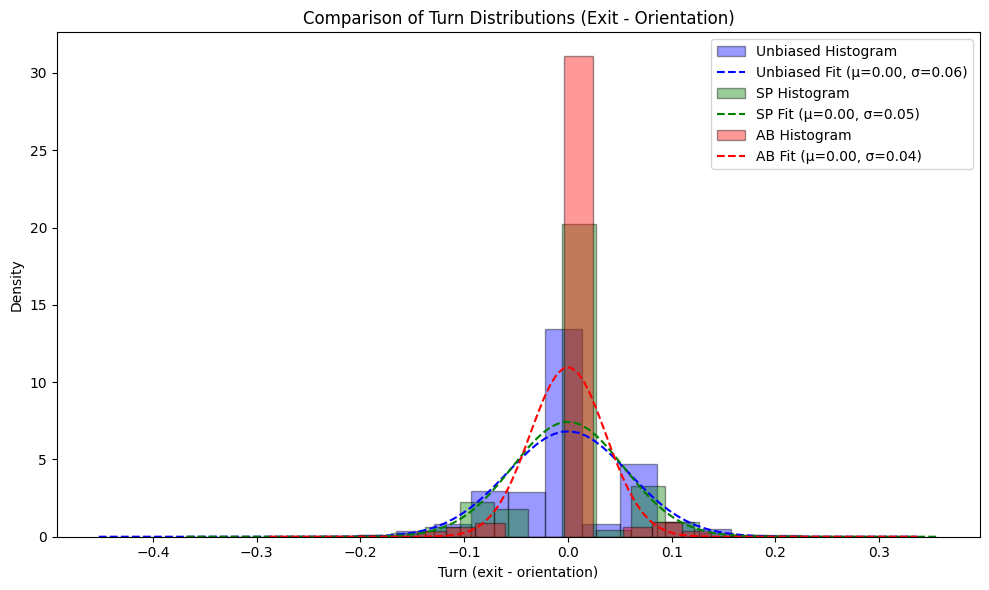


=== Turn Summary Statistics ===
 Dataset  Mean  Std Dev
Unbiased   0.0    0.058
      SP   0.0    0.054
      AB   0.0    0.036


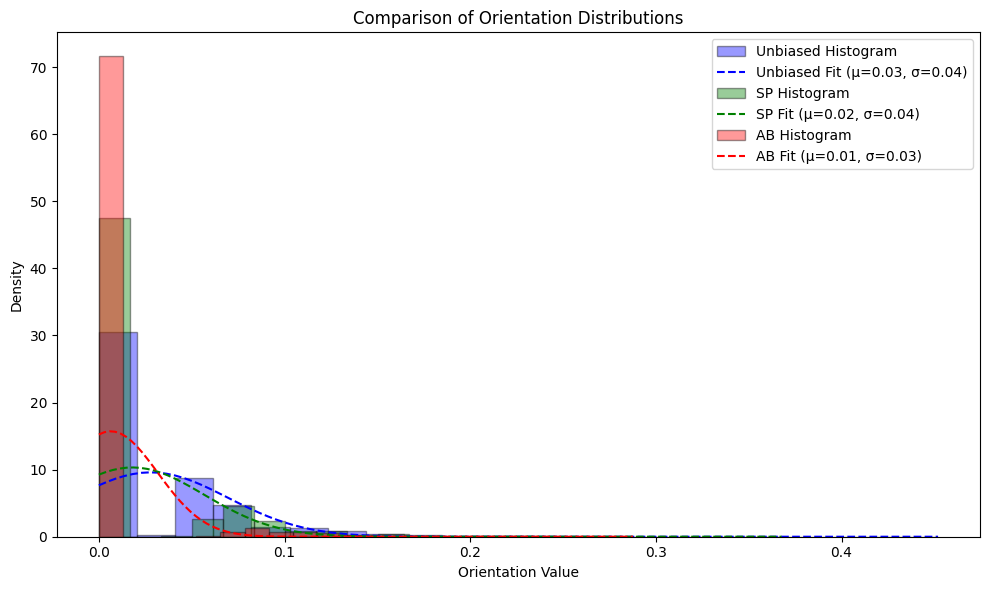


=== Orientation Summary Statistics ===
 Dataset  Mean  Std Dev
Unbiased 0.028    0.042
      SP 0.018    0.039
      AB 0.006    0.025


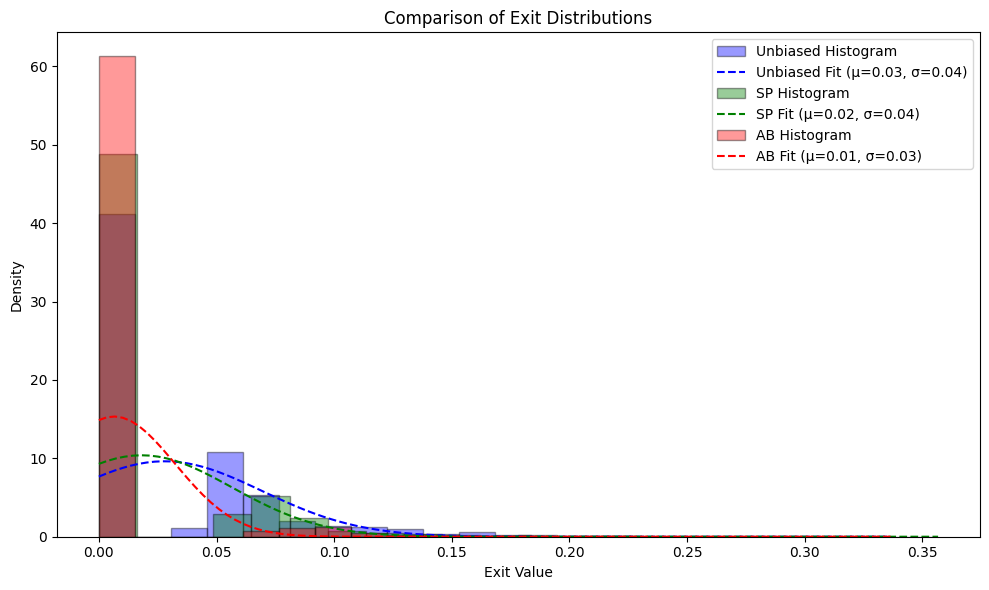


=== Exit Summary Statistics ===
 Dataset  Mean  Std Dev
Unbiased 0.028    0.041
      SP 0.018    0.038
      AB 0.006    0.026


In [335]:
# Plot and provide print-out of gamma distribution parameter estimates

colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']
datasets = [
    (unbiased_exi_2f3[0], unbiased_ori_2f3[0]),
    (sp_exi_2f3[0], sp_ori_2f3[0]),
    (ab_exi_2f3[0], ab_ori_2f3[0])
]

def plot_and_summarize(data_list, labels, colors, title, xlabel):
    """Plot distributions and return stats table."""
    fig, ax = plt.subplots(figsize=(10, 6))
    stats = []

    for data, color, label in zip(data_list, colors, labels):
        clean_data = data[~np.isnan(data)]
        mean = np.nanmean(clean_data)
        std = np.nanstd(clean_data)

        # Fit normal distribution
        mu, sigma = scipy.stats.norm.fit(clean_data)
        x = np.linspace(min(clean_data), max(clean_data), 100)
        pdf = scipy.stats.norm.pdf(x, mu, sigma)

        # Plot histogram
        ax.hist(clean_data, bins=22, alpha=0.4, color=color, edgecolor='black', density=True,
                label=f'{label} Histogram')

        # Plot PDF
        ax.plot(x, pdf, color=color, linestyle='--', label=f'{label} Fit (μ={mu:.2f}, σ={sigma:.2f})')

        # Save stats
        stats.append({'Dataset': label, 'Mean': round(mean, 3), 'Std Dev': round(std, 3)})

    # Final plot setup
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Return stats as DataFrame
    return pd.DataFrame(stats)


### 1. COM_TURN = EXIT - ORI ###
com_turn_data = [exit - ori for exit, ori in datasets]
com_turn_df = plot_and_summarize(com_turn_data, labels, colors,
                                 title='Comparison of Turn Distributions (Exit - Orientation)',
                                 xlabel='Turn (exit - orientation)')
print("\n=== Turn Summary Statistics ===")
print(com_turn_df.to_string(index=False))


### 2. ORIENTATION VALUES ###
ori_data_list = [ori for _, ori in datasets]
ori_df = plot_and_summarize(ori_data_list, labels, colors,
                            title='Comparison of Orientation Distributions',
                            xlabel='Orientation Value')
print("\n=== Orientation Summary Statistics ===")
print(ori_df.to_string(index=False))


### 3. EXIT VALUES ###
exit_data_list = [exit for exit, _ in datasets]
exit_df = plot_and_summarize(exit_data_list, labels, colors,
                             title='Comparison of Exit Distributions',
                             xlabel='Exit Value')
print("\n=== Exit Summary Statistics ===")
print(exit_df.to_string(index=False))

### Moment (mean only) Convergence under Sampling Bias

Note that we assume the theoretical net community turnover distribution mean is zero.

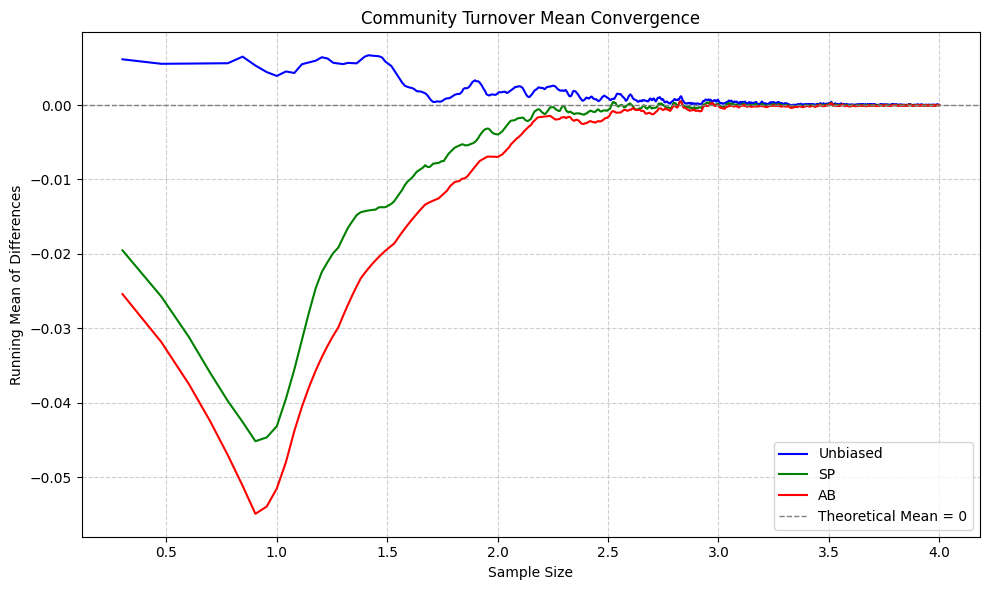

In [336]:
# Plot in log time space

colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']

datasets = [
    unbiased_exi_2f3[0] - unbiased_ori_2f3[0],
    sp_exi_2f3[0] - sp_ori_2f3[0],
    ab_exi_2f3[0] - ab_ori_2f3[0]
]

t = datasets[0].shape[0]

running_means = []

for data in datasets:
    means = [np.nanmean(data[:i]) for i in range(2, t)]
    running_means.append(means)

samples = np.arange(2, t)

plt.figure(figsize=(10, 6))

for i, means in enumerate(running_means):
    y1 = np.convolve(means, np.ones(10)/10, mode='same')
    plt.plot(np.log10(samples), y1, label=labels[i], color=colors[i])

plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Theoretical Mean = 0')
plt.xlabel('Sample Size')
plt.ylabel('Running Mean of Differences')
plt.title('Community Turnover Mean Convergence')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

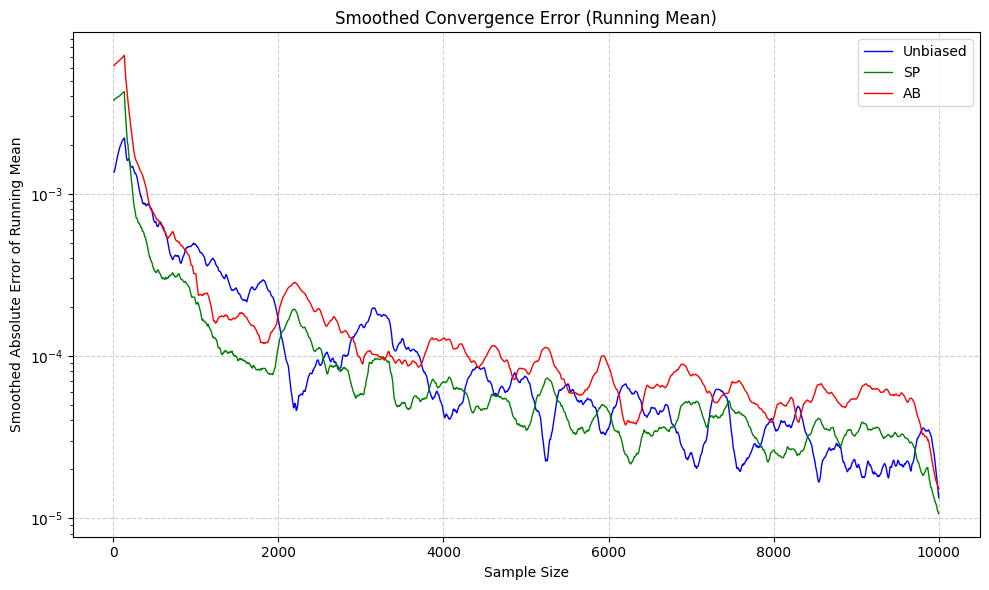

In [337]:
# Plot of Convergence Error

colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']

# Datasets are difference arrays (Exi - Ori)
datasets = [
    unbiased_exi_2f3[0] - unbiased_ori_2f3[0],
    sp_exi_2f3[0] - sp_ori_2f3[0],
    ab_exi_2f3[0] - ab_ori_2f3[0]
]

t = datasets[0].shape[0]
true_mean = 0
start_i = 10

running_means = {label: [] for label in labels}
running_errors = {label: [] for label in labels}

# Compute running means and errors
for data, label in zip(datasets, labels):
    means = []
    errors = []

    for i in range(start_i, t):
        window = data[:i]
        if np.isnan(window).all() or np.allclose(window, 0):
            means.append(np.nan)
            errors.append(np.nan)
            continue
        current_mean = np.nanmean(window)
        means.append(current_mean)
        errors.append(abs(current_mean - true_mean))

    running_means[label] = means
    running_errors[label] = errors

samples = np.arange(start_i, t)

# === Smoothing Parameters ===
kernel_size = 250  # Adjust as needed
kernel = np.ones(kernel_size) / kernel_size

# === Plotting ===
plt.figure(figsize=(10, 6))

for label, color in zip(labels, colors):
    error_array = np.array(running_errors[label])
    sample_array = np.array(samples)

    # Mask invalid values
    mask = ~np.isnan(error_array) & (error_array > 1e-10)
    filtered_errors = error_array[mask]
    filtered_samples = sample_array[mask]

    # Apply smoothing (use 'same' to maintain length)
    smoothed_errors = np.convolve(filtered_errors, kernel, mode='same')

    # Plot smoothed error
    plt.plot(filtered_samples, smoothed_errors, label=label, color=color, linewidth=1)

plt.yscale('log')
plt.xlabel('Sample Size')
plt.ylabel('Smoothed Absolute Error of Running Mean')
plt.title('Smoothed Convergence Error (Running Mean)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()